In [2]:
import pandas as pd

## Data analysis and preprocessing

In [140]:
diamonds_df = pd.read_csv('datasets\diamonds\diamonds.csv')
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [26]:
diamonds_df.info()
# There are 9 features, of which 3 are categorical (cut, color and clarity) and 6 numerical (float64). The targe variable, price, is int64.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


In [27]:
diamonds_df.isna().sum()
#There are no missing values

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

#### Statistical analysis

In [28]:
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


Some interesting insigths:

    - comparing the mean of each feature, they have very different scale, so they should be scaled to the same range
    - x,y and z have min=0, which means there's one or more outliers that should be removed since this are physical quantities  
    - price has min=-1, which also indicates the presence of outliers since the price must be greater than 0

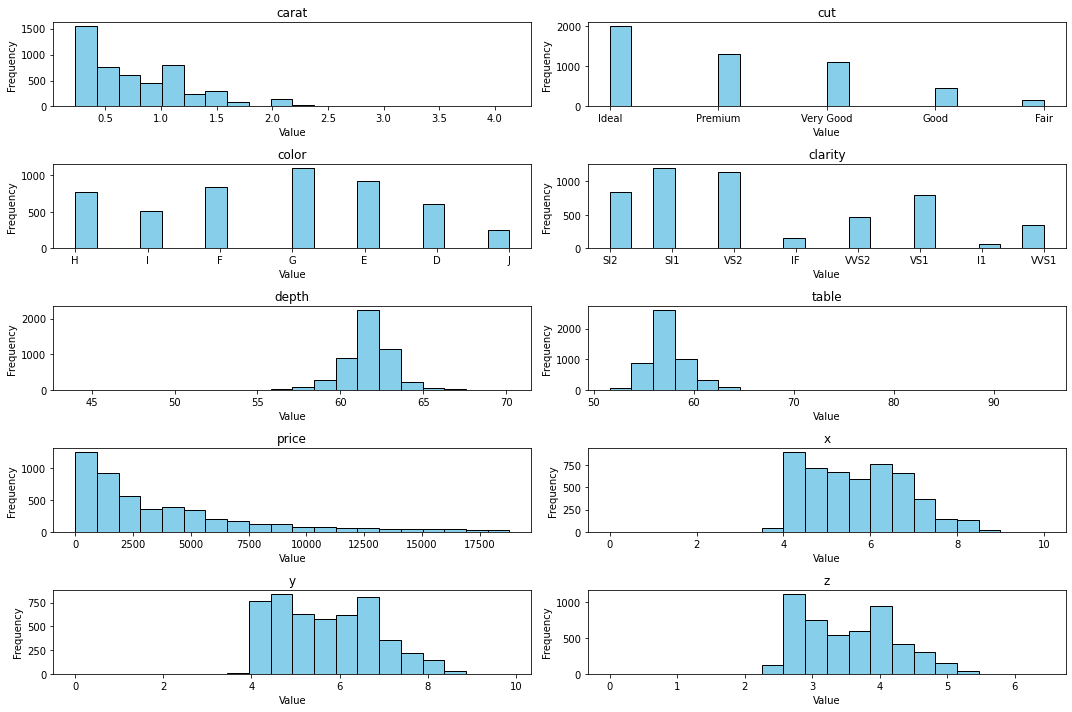

In [29]:
#Plot the distribution of each variable
import matplotlib.pyplot as plt

def plot_distribution(df):
    # Get the column names
    columns = df.columns
    
    # Define the number of rows and columns for subplots
    num_rows = len(columns) // 2
    num_cols = 2 if len(columns) % 2 == 0 else 3
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    
    # Flatten the axes if necessary
    if num_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot each column
    for i, col in enumerate(columns):
        ax = axes[i]
        ax.hist(df[col], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Call the function with your dataframe
plot_distribution(diamonds_df)


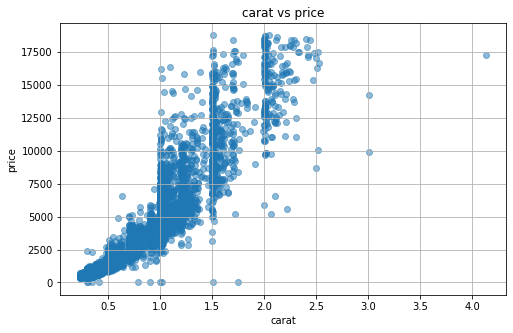

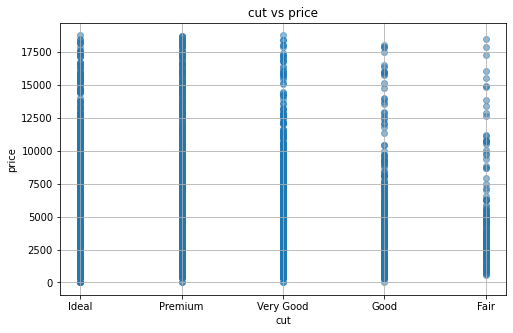

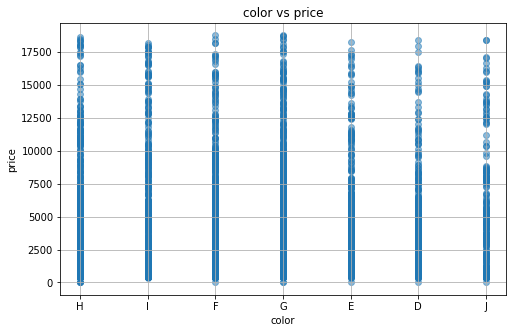

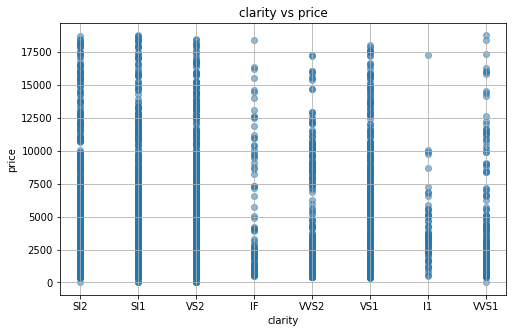

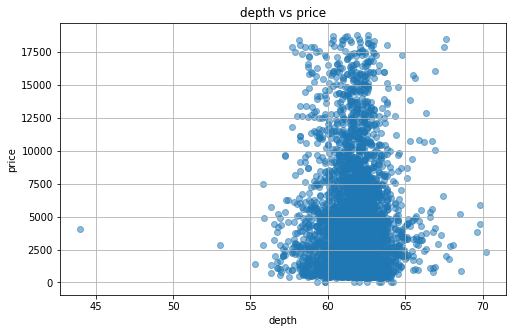

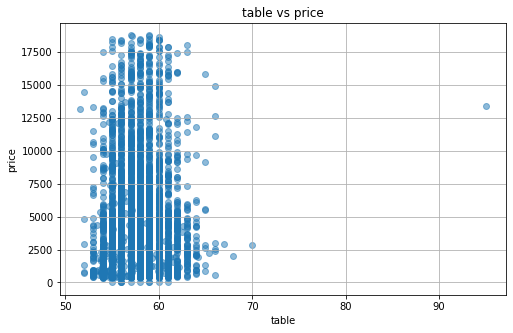

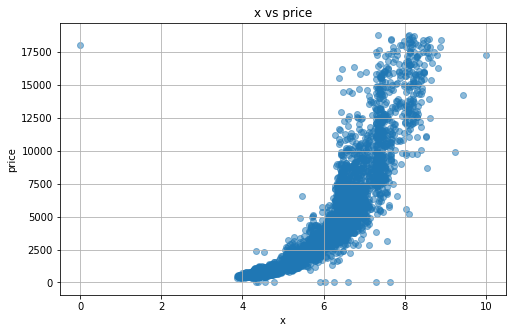

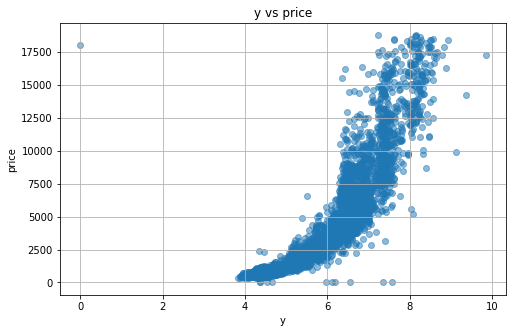

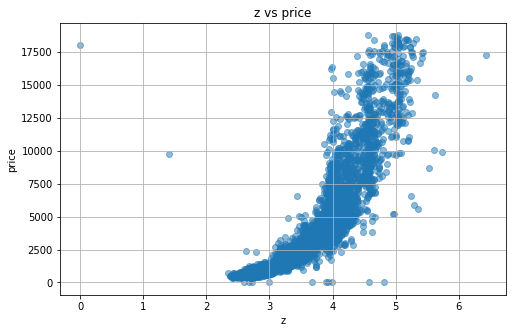

In [30]:
#Plot each feature against price
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'target' is the name of the target column
target_column = 'price'

# Get the list of column names excluding the target column
feature_columns = [col for col in diamonds_df.columns if col != target_column]

# Plot each feature against the target
for feature in feature_columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(diamonds_df[feature], diamonds_df[target_column], alpha=0.5)
    plt.title(f'{feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)
    plt.grid(True)
    plt.show()

This kind of scatterplots are more useful for numerical variables. For the categorical, the histograms plotted above are better.  
Insights:
- x,y,z do not seem linearly related to the price
- both depth and table don't show much relationship with price

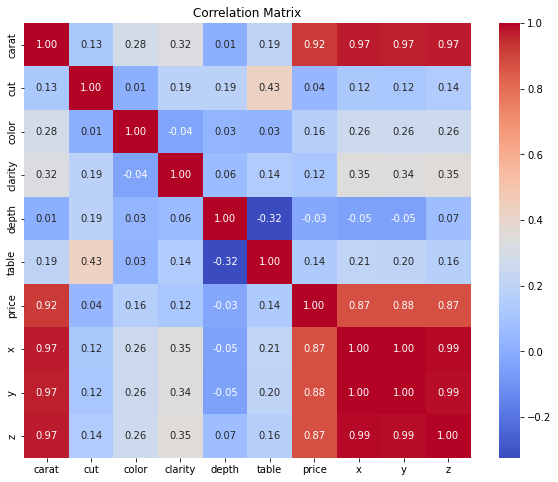

In [123]:
#Check correlation between features
import pandas as pd

# Assuming df is your DataFrame
correlation_matrix = diamonds_df.corr()

# You can also visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


We see some cases of highly correlated variables: x, y, z and carat. This is a problem for linear regression, as it's not possible to asses the independent effect of each variable on the price.

#### Handling outliers
In the previous plots, there are points that appear to be outliers. For example, the point with x=0, y=0, z=0 is crearly a mistake and should be removed. Also the points with price=-1, which don't provide any useful information.

In [59]:
diamonds_df[diamonds_df['z'] == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z
4321,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0


In [60]:
diamonds_df[diamonds_df['price'] < 0]

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


In [141]:
diamonds_df = diamonds_df[diamonds_df['price'] > 0]
diamonds_df = diamonds_df[diamonds_df['z'] > 0]
diamonds_df.reset_index(drop=True, inplace=True)

#### Handling categorical data
The categorical variables are cut, color and clarity. The three of them are ordinal, meaning that there's an order between variables. For example, for 'cut', 'Good' > 'Fair', and 'Premium' >> 'Fair'. The same applies to 'color' and 'clarity' (judging from the reference images provided in _md-images). So we can use ordinal encoding, which assigns a numeric value to each variable.
If there was no relationship between classes (for example, in a variable 'country'), one-hot encoding should be used instead, but this come with the disadvantage of increasing the dimensionality of the data.  

In [7]:
print(diamonds_df['cut'].unique())
print(diamonds_df['color'].unique())
print(diamonds_df['clarity'].unique())

['Ideal' 'Premium' 'Very Good' 'Good' 'Fair']
['H' 'I' 'F' 'G' 'E' 'D' 'J']
['SI2' 'SI1' 'VS2' 'IF' 'VVS2' 'VS1' 'I1' 'VVS1']


In [62]:
cut_order = [['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']]
color_order = [['D','E','F','G','H','I','J']]
clarity_order = [['IF','VVS1', 'VVS2','VS1','VS2','SI1','SI2','I1']]

In [63]:
from sklearn.preprocessing import OrdinalEncoder
cut_encoder  = OrdinalEncoder(categories=cut_order)
color_encoder  = OrdinalEncoder(categories=color_order)
clarity_encoder  = OrdinalEncoder(categories=clarity_order)
diamonds_df['cut']  = cut_encoder.fit_transform(diamonds_df['cut'].values.reshape(-1, 1))
diamonds_df['color']  = color_encoder.fit_transform(diamonds_df['color'].values.reshape(-1, 1))
diamonds_df['clarity']  = clarity_encoder.fit_transform(diamonds_df['clarity'].values.reshape(-1, 1))


In [64]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,0.0,4.0,6.0,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,0.0,4.0,5.0,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,1.0,5.0,5.0,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,0.0,2.0,5.0,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,2.0,2.0,4.0,61.7,57.0,4493,6.17,6.21,3.82


#### Data scaling
min-max scaling is more sensitive to outliers, so I chose z-score scaling instead

In [142]:
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'price' is the name of the target column
columns_to_scale =diamonds_df.columns[diamonds_df.columns != 'price']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to the data (excluding the target column)
scaler.fit(diamonds_df[columns_to_scale])

# Transform the data
scaled_data = scaler.transform(diamonds_df[columns_to_scale])

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Concatenate the scaled DataFrame with the target column
scaled_df['price'] = diamonds_df['price']

# Now 'scaled_df' contains all columns standardized except for the 'price' column


In [143]:
scaled_df.describe()

,carat,depth,table,x,y,z,price
count,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4989.000000
mean,7.450444e-17,-1.453805e-15,2.283206e-15,4.103530e-16,-1.202575e-16,1.243699e-15,3930.581880
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,3970.923311
min,-1.205548e+00,-1.225310e+01,-2.587376e+00,-1.672033e+00,-1.703090e+00,-3.085091e+00,351.000000
25%,-8.422491e-01,-4.917912e-01,-6.400643e-01,-9.194428e-01,-9.186387e-01,-9.205513e-01,942.000000
50%,-2.011331e-01,6.168191e-02,-1.974935e-01,-3.246146e-02,-2.598734e-02,-5.343205e-03,2398.000000
75%,5.254649e-01,5.459709e-01,6.876480e-01,7.290881e-01,7.314138e-01,7.210124e-01,5376.000000
max,7.128959e+00,5.873150e+00,1.662020e+01,3.829043e+00,3.715935e+00,4.207519e+00,18787.000000


#### Data splitting

In [147]:
from sklearn.model_selection import train_test_split

# Assuming df is your dataframe and target_column is the name of your target variable column
X = scaled_df.drop(columns=['price'])  # Features
y = scaled_df['price']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
X_train

,carat,depth,table,x,y,z,cut,color,clarity
4855,0.461353,-1.460369,0.687648,0.720129,0.659280,0.488579,Premium,E,SI1
3012,3.025817,-1.114449,1.130219,2.458254,2.525733,2.289941,Ideal,G,SI2
879,-0.884990,-0.353423,-0.640064,-0.946321,-0.918639,-0.964133,Very Good,E,VS2
2927,-0.863620,0.200050,-1.525206,-0.919443,-0.909622,-0.891497,Ideal,F,VVS2
2696,0.482724,-0.353423,-0.640064,0.684291,0.704364,0.648377,Ideal,H,SI1
...,...,...,...,...,...,...,...,...,...
4426,-0.564432,-0.007502,-0.197494,-0.480432,-0.458788,-0.470211,Very Good,G,VVS1
466,-1.055954,0.130866,0.687648,-1.277819,-1.270289,-1.254675,Premium,G,VS1
3092,1.935920,0.545971,1.572789,1.625029,1.551932,1.679802,Premium,F,VS2
3772,0.226277,0.200050,-0.640064,0.388631,0.451897,0.444997,Ideal,I,SI1


## Model selection

#### Linear regression

Considering the context of the problem, the chosen model should perform regression (as the targe variable 'price' is numerical) and should alse be interpretable (because the clients want to know how the price is calculated). So a first try would be a linear regression, but before we need to check if the data fullfils the linear regression assumptions.

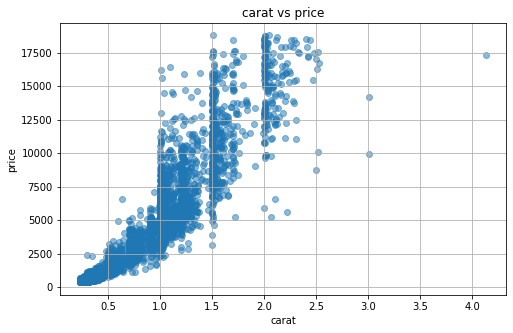

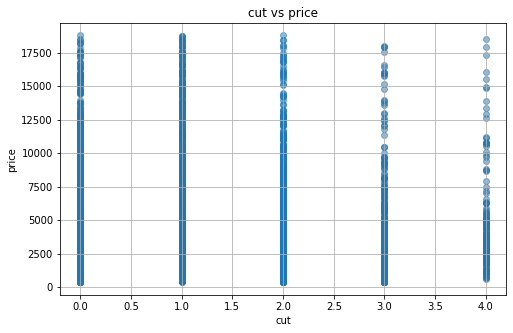

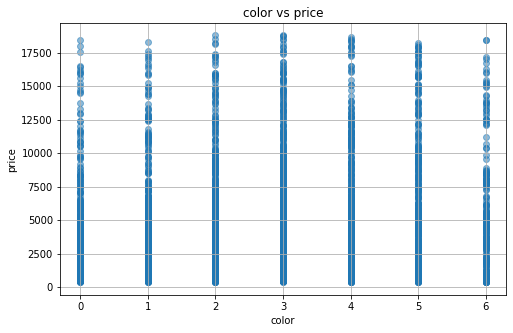

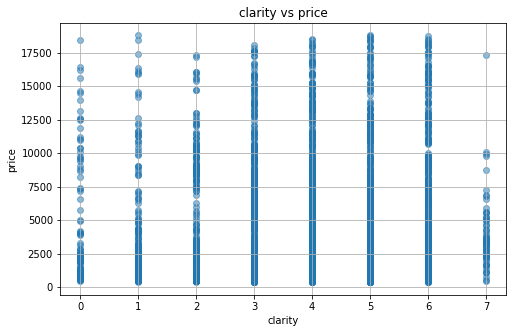

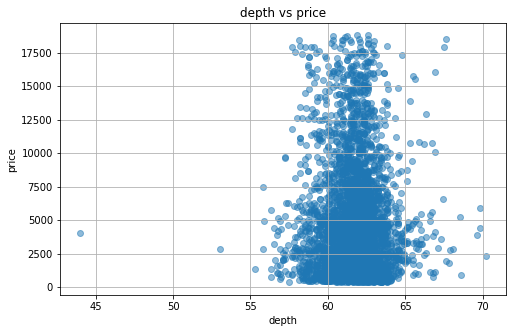

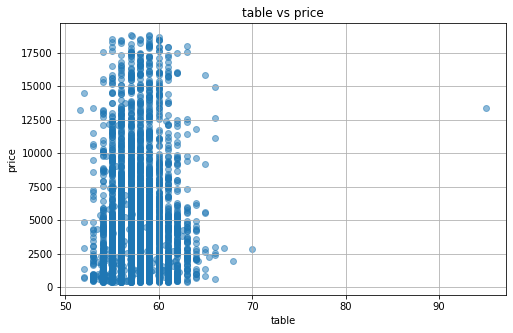

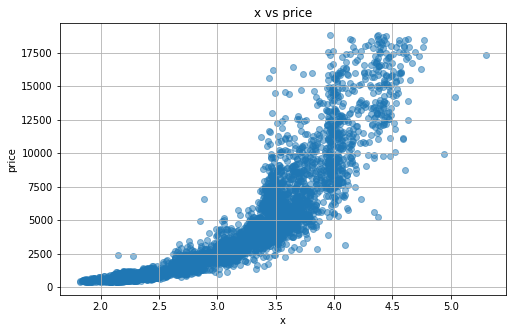

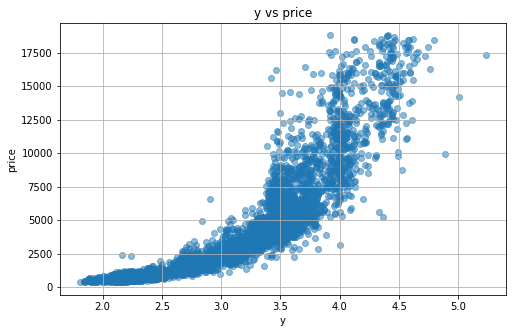

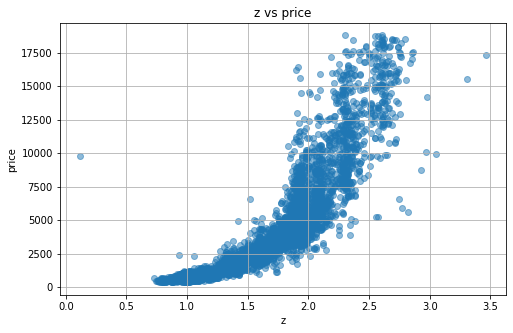

In [97]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'target' is the name of the target column
target_column = 'price'

# Get the list of column names excluding the target column
feature_columns = [col for col in diamonds_df.columns if col != target_column]

# import numpy as np
# diamonds_df['x'] = diamonds_df['x']**2
# diamonds_df['y'] = diamonds_df['y']**2
# diamonds_df['z'] = diamonds_df['z']**2

# Plot each feature against the target
for feature in feature_columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(diamonds_df[feature], diamonds_df[target_column], alpha=0.5)
    plt.title(f'{feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)
    plt.grid(True)
    plt.show()


We see that x,y,z don't have a linear relationship with price, so we can use x^2, y^2,z^2 as features.
depth doens't show any useful relationship with price, so we will discard it.

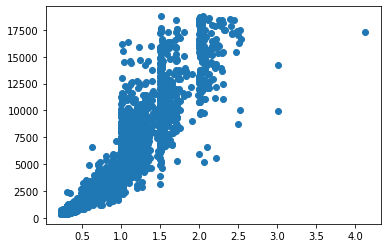

In [119]:
# plt.scatter(diamonds_df['carat'],diamonds_df['price'])

In [114]:
# # Let's calculate Persons coefficient to determine the degree of linearity of the features
# import numpy as np
# from scipy.stats import pearsonr, spearmanr


# feature_values = diamonds_df['price'].values
# target_values = np.exp(diamonds_df['z'].values)
# # Calculate Pearson correlation coefficient
# pearson_corr = np.corrcoef(feature_values, target_values)[0, 1]

# # Calculate Spearman rank correlation coefficient
# spearman_corr, _ = spearmanr(feature_values, target_values)

# print("Pearson correlation coefficient:", pearson_corr)
# print("Spearman rank correlation coefficient:", spearman_corr)


Pearson correlation coefficient: 0.9121696893970974
Spearman rank correlation coefficient: 0.9572310449761514


In [150]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

# Assuming X is your feature matrix and y is your target variable
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LinearRegression model
model = LinearRegression()

# ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
cols = ['carat', 'cut', 'color', 'clarity', 'depth', 'table']#, 'x', 'y', 'z']

# X_train['x'] = np.exp(X_train['x'])#**2
# X_train['y'] = np.exp(X_train['y'])#**2
# X_train['z'] = np.exp(X_train['z'])#**2

# Fit the model on the training data
model.fit(X_train[cols], y_train)

# Predict on the test set
y_pred = model.predict(X_test[cols])

# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)


ValueError: could not convert string to float: 'Premium'

In [89]:
X_train['x']

4855    0.720129
3012    2.458254
879    -0.946321
2927   -0.919443
2696    0.684291
          ...   
4426   -0.480432
466    -1.277819
3092    1.625029
3772    0.388631
860     0.084011
Name: x, Length: 3991, dtype: float64

#### Regression tree
This algorithm doesn't make any assumptions on the data.

In [30]:
feature_columns

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Assuming X is your feature matrix and y is your target variable
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()  # You can adjust the max_depth parameter to control the tree depth

# ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
cols = ['carat', 'cut', 'color','clarity','depth', 'table', 'x', 'y', 'z']

# Train the model
tree_reg.fit(X_train[cols], y_train)

# Predict on the test set
y_pred = tree_reg.predict(X_test[cols])

# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
print("Mean absolute Error:", mse)


ValueError: could not convert string to float: 'Premium'

In [87]:
tree_reg.get_depth()

26

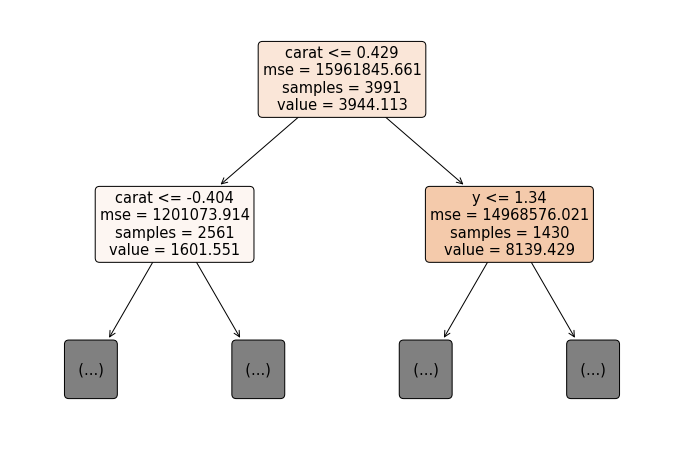

In [53]:
#The clients want to know the price is decided, so let's plot the tree. Only a few levels to keep it interpretable
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Create a decision tree regressor model
# tree_model = DecisionTreeRegressor(max_depth=3)  # Adjust max_depth as needed

# # Fit the model to your training data
# tree_model.fit(X_train, y_train)  # Replace X_train, y_train with your training data

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_reg, max_depth = 1,feature_names=X.columns, filled=True, rounded=True)
plt.savefig('decision_tree.png')
plt.show()



In [51]:
plt.savefig('decision_tree.png')

<Figure size 432x288 with 0 Axes>

In [154]:
# Export the model (solo para el pipeline ch2)
# Once the model is trained, it must be exported to the model registry so that it can be deployed using pytorch
import joblib

joblib.dump(tree_reg, 'tree_reg_model.pt')

['tree_reg_model.pt']

In [54]:
# Assuming you have already trained your decision tree model and named it 'tree_model'

# Get feature importances
feature_importances = tree_reg.feature_importances_

# Get the list of feature names
feature_names = X.columns

# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by importance (descending order)
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted feature names
sorted_feature_names = [feature[0] for feature in sorted_feature_importance]

print("Features ordered by importance:")
for feature in sorted_feature_names:
    print(feature)


Features ordered by importance:
carat
y
clarity
color
x
z
cut
table
depth


## deploy the model (solo para el pipeline ch2)
Once the model is trained, it must be exported to the model registry so that it can be deployed using pytorch

In [156]:
# !pip install torch

  Using cached typing_extensions-4.10.0-py3-none-any.whl (33 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.3.0
    Uninstalling typing-extensions-4.3.0:
      Successfully uninstalled typing-extensions-4.3.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.3.3 which is incompatible.


In [157]:
import torch

# Load the serialized model using PyTorch
class RegressionTreeModel(torch.nn.Module):
    def __init__(self):
        super(RegressionTreeModel, self).__init__()
        self.tree = joblib.load('tree_reg_model.pt')

    def forward(self, x):
        # Assume the tree.predict() method is used to make predictions
        return torch.tensor(self.tree.predict(x))

# Instantiate the model
model = RegressionTreeModel()

# Use the model for inference
# Assuming X_test is your test data
predictions = model(torch.tensor(X_test))
predictions


ValueError: could not determine the shape of object type 'DataFrame'